In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonia-7997/amazonia-791997-9eddf18d6574.json
/kaggle/input/archeoblog-centroids/archeoblog_geoglyph_centroids.csv
/kaggle/input/archeo-centroid-desc/archeoblog_centroids_desc.csv
/kaggle/input/archeoblog-results/amazon_results.kml


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.5 MB/s eta 0:00:00:00:0100:01


In [3]:
from openai import OpenAI
from kaggle_secrets import UserSecretsClient
import ee, openai
import google.api_core
import rich
import subprocess
import base64
import io
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import pandas as pd
import json
import re
from shapely.geometry import Point
from shapely.ops import transform
from shapely.ops import transform as shp_transform
import shapely.wkt
from shapely.geometry import LineString
import pyproj
from geopy.distance import geodesic
import os
import pyproj
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import requests, rasterio, tempfile, cv2
import glob, zipfile
import xml.etree.ElementTree as ET
import geopandas as gpd
from bs4 import BeautifulSoup

In [4]:
def load_secret(name):
    """Loads secret from Colab/Kaggle."""

    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        try:
            from kaggle_secrets import UserSecretsClient
            return UserSecretsClient().get_secret(name)
        except Exception:
            pass 
    else:
        try:
            from google.colab import userdata
            return userdata.get(name)
        except Exception: 
            pass

    return 'Secret not found'

In [5]:
openai_key = load_secret('OPENAI_API_KEY')
client = OpenAI(api_key=openai_key)

In [6]:
iam_service_account = load_secret('iam_service_account') # the address of your project's IAM service account
ee_credentials_json = load_secret('ee_credentials') # the file path for the JSON file containing the relevant credentials
ee_creds = ee.ServiceAccountCredentials(iam_service_account, ee_credentials_json) # fetch your service account credentials
ee.Initialize(ee_creds) 

**#### CHECKPOINT 1 ####**

In [7]:
# Checking of the available OpenLandMap soil layers
assets = ee.data.listAssets({'parent': 'OpenLandMap/SOL'})
for a in assets.get('assets', []):
    print(a['id'])

OpenLandMap/SOL/SOL_BULKDENS-FINEEARTH_USDA-4A1H_M
OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M
OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX-HAPLUDALFS_P
OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX_C
OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M
OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M
OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M
OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M
OpenLandMap/SOL/SOL_WATERCONTENT-33KPA_USDA-4B1C_M


**Thinking process to narrow down to one coordinate**

**High-C areas:** Compute soil organic carbon percentiles to mask regions with >5 g C/kg, indicating possible terra preta.

**Vegetation anomalies:** Extract pixels where NDVI exceeds its 99th percentile within 2 km of major rivers, flagging potential buried ditches or clearings.

**River proximity:** Select all pixels within 2 km of river geometries to capture settlement-water relationships.

**Known sites:** Import ArcheoBlog centroids and filter to our survey box as ground-truth candidates.

**Voting scheme:** Merge all candidate points, annotate each with boolean flags for proximity to soil, NDVI, river, and Archeo features, then sum these flags into a ‘votes’ score.

**Final pick:** Sort by votes (≥2) and take the top feature—this yields the single seed coordinate that best satisfies multiple archaeological indicators.

**Why this region?**
I chose this initial Rectangle [-68.228, -10.225, -67.772, -9.775] because it precisely bounds the core geoglyph-rich interfluve between the Iquiri and Acre Rivers in southeastern Acre, Brazil—a hotspot where J.Q. Jacobs’ ArcheoBlog has cataloged hundreds of geometric earthworks and where studies by de Souza et al. (2018) and Iriarte et al. (2020) report exceptionally high densities of pre-Columbian enclosures and mound villages 

In [8]:
survey_area = ee.Geometry.Rectangle([-68.228, -10.225, -67.772, -9.775])

sentinel_l2a = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(survey_area)
                  .filterDate('2024-01-01','2024-12-31')
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
                  .median().clip(survey_area))

rivers_fc = (ee.FeatureCollection('WWF/HydroSHEDS/v1/FreeFlowingRivers')
               .filter(ee.Filter.gte('STRAHLER_ORD',5))
               .filterBounds(survey_area))

soil_oc = (
    ee.Image('OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02')  # ← note the /v02
      .select('b0')               # the organic-carbon fraction [g/kg]
      .clip(survey_area)
)


# 1) Terra preta centroids → pts1_fc
highC   = soil_oc.gt(5).selfMask()
pts1_fc = highC.reduceToVectors(geometry=survey_area, scale=1000, geometryType='centroid', maxPixels=1e13).map(lambda f: f.set('src', 1))


# 2) NDVI ≥ 99th pct within 2 km of rivers → pts2_fc
ndvi      = sentinel_l2a.normalizedDifference(['B8','B4'])
p99       = ndvi.reduceRegion(ee.Reducer.percentile([99]), survey_area, 1000).get('nd')
# p_dict = p99.getInfo()
# print("Available keys:", list(p_dict.keys()))
hot       = ndvi.gt(ee.Number(p99))
nearRiv   = rivers_fc.geometry().buffer(2000)
pts2_fc   = hot.updateMask(hot).clip(nearRiv).reduceToVectors(geometry=survey_area, scale=100, geometryType='centroid', maxPixels=1e13).map(lambda f: f.set('src', 2))

# 3) Pixels within 2 km of rivers → pts3_fc
river_mask = ee.Image().byte().paint(rivers_fc, 1, 1)
pixel_size = 100
radius_px  = 2000 / pixel_size
kernel = ee.Kernel.euclidean(radius_px, units='pixels')

distImg = river_mask.distance(kernel).rename('dist') 
# pixels <2 000 m from a river; mask out everything else
pts3_fc = (distImg.lt(2000).selfMask().reduceToVectors(geometry=survey_area, scale=100, geometryType='centroid', maxPixels=1e13).map(lambda f: f.set('src', 3)))

In [9]:
#Checking 95th percentile for Soil Organic Carbon Content
stats = soil_oc.reduceRegion(
    reducer=ee.Reducer.percentile([0,25,50,75,90,95,99]),
    geometry=survey_area,
    scale=1000,
    bestEffort=True
).getInfo()

print("Soil OC percentiles (g C / kg):", stats)

Soil OC percentiles (g C / kg): {'b0_p0': 2, 'b0_p25': 3.000000000000006, 'b0_p50': 4, 'b0_p75': 4, 'b0_p90': 4, 'b0_p95': 5, 'b0_p99': 7}


archeoblog_geoglyph_centroids.csv is a csv file I created from the ArcheoBlogs amazon_geoglyphs.kml file

In [10]:
df = pd.read_csv('/kaggle/input/archeoblog-centroids/archeoblog_geoglyph_centroids.csv')
#  Turn each row into an ee.Feature with a real ee.Geometry.Point
features = []
for _, row in df.iterrows():
    lon = float(row['longitude'])
    lat = float(row['latitude'])
    props = {
      'name': row['name']
      
    }
    pt   = ee.Geometry.Point([lon, lat])
    feat = ee.Feature(pt, props)
    features.append(feat)

#  Pack them into an EE FeatureCollection
pts4_fc = ee.FeatureCollection(features)
pts4_fc = pts4_fc.filterBounds(survey_area)

#  Test it
print(pts4_fc.limit(5).getInfo())

{'type': 'FeatureCollection', 'columns': {'name': 'String', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-67.840479, -10.212045333333334]}, 'id': '15', 'properties': {'name': 'abuno-acrc60-assis'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-67.90556966666666, -10.195391]}, 'id': '17', 'properties': {'name': 'abuno-bdese-assis'}}]}


Checking Minimum Distance between Combinations of Data sources

In [11]:
def addMinDist(fcA, fcB, label):
    def compute(f):
        #  For this feature f, compute a FeatureCollection of zero‐geometry
        #   features whose only property is the distance to each b in fcB.
        dists_fc = fcB.map(lambda b: ee.Feature(None, {
            'd': b.geometry().distance(f.geometry())
        }))
        #  Turn that into a List of numbers via aggregate_array:
        dists_list = dists_fc.aggregate_array('d')
        #  Take the min of the list with a reducer:
        minDist = ee.Number(dists_list.reduce(ee.Reducer.min()))
        #  Attach it to f
        return f.set(f'{label}_minDist', minDist)
    return fcA.map(compute)

In [12]:
pairs = [
    ('soil',  pts1_fc, 'ndvi',    pts2_fc),
    ('soil',  pts1_fc, 'river',   pts3_fc),
    ('soil',  pts1_fc, 'archeo',  pts4_fc),
    ('ndvi',  pts2_fc, 'river',   pts3_fc),
    ('ndvi',  pts2_fc, 'archeo',  pts4_fc),
    ('river', pts3_fc, 'archeo',  pts4_fc),
]

In [13]:
# Loop and report
for nameA, fcA, nameB, fcB in pairs:
    # Add the minDist property to each feature in fcA
    fc_with_dist = addMinDist(fcA, fcB, nameB)
    # Compute summary stats of that new property
    stats = fc_with_dist.aggregate_stats(f'{nameB}_minDist').getInfo()
    print(f"{nameA} → {nameB} distance (m):", stats)

soil → ndvi distance (m): {'max': 2658.3328705418394, 'mean': 745.2646603980502, 'min': 216.35620120792254, 'sample_sd': 755.7730011702283, 'sample_var': 571192.829297854, 'sum': 8943.175924776602, 'sum_sq': 12948154.090735046, 'total_count': 12, 'total_sd': 723.5975586307393, 'total_var': 523593.42685636616, 'valid_count': 12, 'weight_sum': 12, 'weighted_sum': 8943.175924776602}
soil → river distance (m): {'max': 15880.027925101173, 'mean': 9430.223374280153, 'min': 1421.3312310504475, 'sample_sd': 3949.165192013236, 'sample_var': 15595905.713808937, 'sum': 113162.68049136184, 'sum_sq': 1238704317.5177355, 'total_count': 12, 'total_sd': 3781.037807841236, 'total_var': 14296246.90432486, 'valid_count': 12, 'weight_sum': 12, 'weighted_sum': 113162.68049136184}
soil → archeo distance (m): {'max': 51944.227805246606, 'mean': 25370.871579092334, 'min': 3000.4109068252887, 'sample_sd': 12615.8192446538, 'sample_var': 159158895.21377718, 'sum': 304450.458949108, 'sum_sq': 9474921343.545092, 

Checking overlap between the Pairs of Data sources

In [14]:
def count_within(fcA, fcB, name, dist):
    def annotate(f):
        buf    = f.geometry().buffer(dist)
        n_near = fcB.filterBounds(buf).size()
        return f.set(f'{name}_near', n_near)
    with_counts = fcA.map(annotate)
    positive   = with_counts.filter(ee.Filter.gt(f'{name}_near', 0))
    print(f"{name} overlaps:", positive.size().getInfo())

# example at 50 km
count_within(pts1_fc, pts2_fc, 'soil_vs_ndvi', 2000)
count_within(pts1_fc, pts3_fc, 'soil_vs_river',  2000)
count_within(pts1_fc, pts4_fc, 'soil_vs_archeo', 2000)
count_within(pts2_fc, pts3_fc, 'ndvi_vs_river', 2000)
count_within(pts2_fc, pts4_fc, 'ndvi_vs_archeo',  2000)
count_within(pts3_fc, pts4_fc, 'river_vs_archeo', 2000)

soil_vs_ndvi overlaps: 11
soil_vs_river overlaps: 1
soil_vs_archeo overlaps: 0
ndvi_vs_river overlaps: 191
ndvi_vs_archeo overlaps: 16
river_vs_archeo overlaps: 0


In [15]:
# 1) Merge all your candidate points
all_pts = pts1_fc.merge(pts2_fc).merge(pts3_fc).merge(pts4_fc)

# 2) A factory that returns a mapper adding e.g. "soil_near" (True/False)
def is_near(fcB, dist, label):
    def annotate(f):
        # Boolean: does fcB have ≥1 feature within `dist` meters of f?
        near = fcB.filterBounds(f.geometry().buffer(dist)).size().gt(0)
        return f.set(f"{label}_near", near)
    return annotate

# 3) Apply it for each source, using a 2 km buffer
scored = all_pts
for fc, label in [
    (pts1_fc, 'soil'),
    (pts2_fc, 'ndvi'),
    (pts3_fc, 'river'),
    (pts4_fc, 'archeo'),
]:
    scored = scored.map(is_near(fc, 2000, label))

# 4) Sum up the four True/False flags into a numeric 'votes'
def tally(f):
    flags = ['soil_near','ndvi_near','river_near','archeo_near']
    # Convert each boolean to 1 or 0
    ones = ee.List(flags).map(lambda k: ee.Number(ee.Algorithms.If(f.get(k), 1, 0)))
    total = ee.Array(ones).reduce('sum', [0]).get([0])
    return f.set('votes', total)

tallied = scored.map(tally)

# 5) Filter for ≥2 votes, sort highest first, grab the top
cands = tallied.filter(ee.Filter.gte('votes', 2))
top   = ee.Feature(cands.sort('votes', False).first())

# 6) Extract lon/lat and vote count
lon, lat = top.geometry().coordinates().getInfo()
votes    = top.get('votes').getInfo()
print(f"Chosen seed point: {lon:.6f}, {lat:.6f}  ({votes} votes)")


Chosen seed point: -68.155256, -9.796273  (3 votes)


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Sentinel-2 scene ID: 20240724T144731_20240724T145108_T19LEK
bbox: [-68.18242934679445, -9.82325922242945, -68.12799689863108, -9.769276402145533]


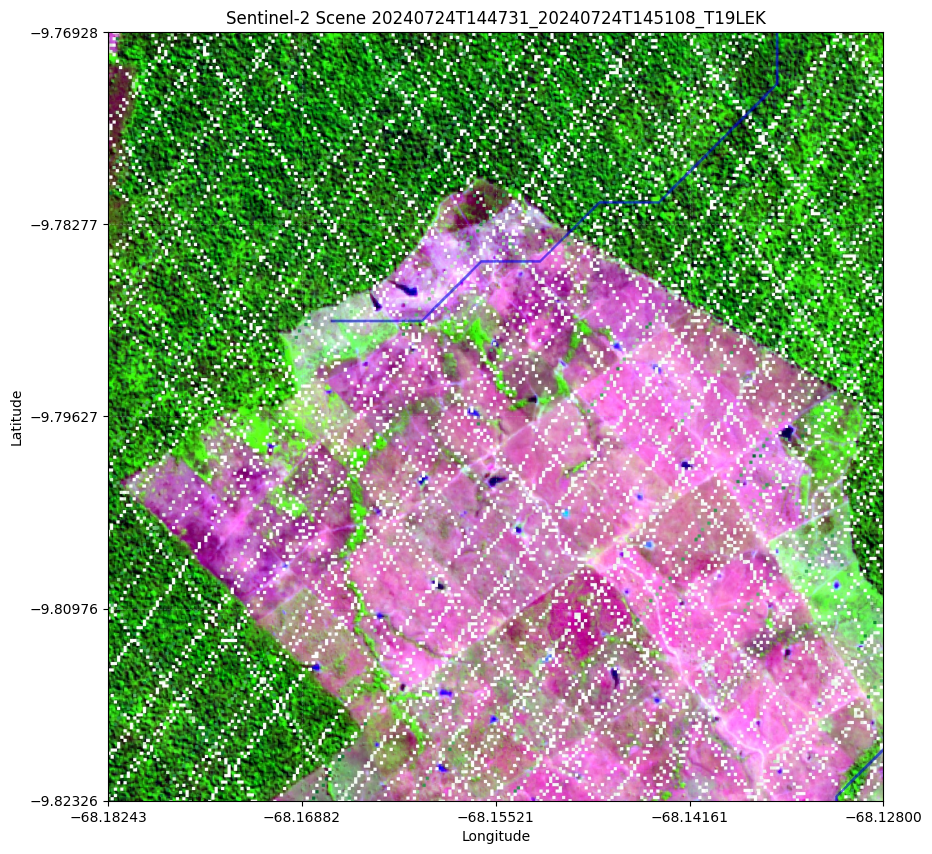

In [16]:
coordinates = [-68.155256, -9.796273]  #[-52.25, -11.50 ]
amazon_pt = ee.Geometry.Point(coordinates)
region = amazon_pt.buffer(3000).bounds()


s2 = (ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(region) \
    .filterDate('2024-01-01', '2024-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    )

def mask_clouds(img):
    scl = img.select('SCL')
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    return img.updateMask(mask)

# Grab the *first* low‐cloud image for metadata
scene_img   = s2.map(mask_clouds) \
                .sort('CLOUDY_PIXEL_PERCENTAGE') \
                .first() \
                .clip(region)

sentinel = s2.map(mask_clouds).median().clip(region)

scene_id = scene_img.get('system:index').getInfo()
print("Sentinel-2 scene ID:", scene_id)

bands = ['B11', 'B8', 'B4']

# Compute per-band 2nd/98th percentiles over the region
p = sentinel.reduceRegion(
    reducer=ee.Reducer.percentile([2,98]),
    geometry=region,
    scale=10,
    bestEffort=True
)

p_vals = {b: (ee.Number(p.get(f'{b}_p2')), ee.Number(p.get(f'{b}_p98'))) for b in bands }

def stretch(img, mn, mx):
    return img.subtract(mn).divide(mx.subtract(mn)).clamp(0,1)

stretched = ee.Image.cat(*[
    stretch(sentinel.select(b), *p_vals[b]).rename(b)
    for b in bands
])

vis_s2 = {
    'bands': bands,
    'min': 0,
    'max': 1.0,
    'gamma': [1.2, 1.0, 1.0]
}

gedi_monthly = (ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY').filterBounds(amazon_pt).select('rh100'))
gedi_pts = gedi_monthly.mosaic().clip(region).gt(5)
# raster of mean canopy height : white (ffffff): bare or low -> light green (a1d99b) -> mid-green (31a354) -> dark green (006d2c): tall forest
canopy_ht = gedi_monthly.median().clip(region)
vis_gedi = {
    'min': 0,
    'max': 50,
    'palette': ['ffffff','a1d99b','31a354','006d2c']
}


#  Load & filter the table index
index_fc = (ee.FeatureCollection('LARSE/GEDI/GEDI02_A_002_INDEX')
              .filterBounds(region))

#  Get the list of table-asset IDs in this region (client-side)
table_ids = index_fc.aggregate_array('table_asset_id').getInfo()


#  For each table ID, load and style the points
point_images = []
for tid in table_ids:
    fc = (ee.FeatureCollection(tid)
            .filterBounds(region)
            .filter(ee.Filter.gt('rh100', 5)))       # only true canopy returns
    img = fc.style(                                 # style parameters style() accepts
        color='00FF00',
        pointSize=2,
        pointShape='circle'
    ).visualize(opacity=0.6)                       # then add opacity
    point_images.append(img)

rivers = ee.FeatureCollection('WWF/HydroSHEDS/v1/FreeFlowingRivers')
major = rivers.filter(ee.Filter.gte('STRAHLER_ORD', 5))

river_img = ee.Image().byte().paint(
    major,   # the FeatureCollection
    4,       # color value to paint
    4        # line width in pixels
)

vis_riv = {
    'palette': ['0000FF'],
    'opacity': 0.6
}


if sentinel is None:
    raise ValueError("No suitable Sentinel-2 image found.")

thumb_img = ee.ImageCollection([
    stretched.visualize(**vis_s2), #RGB jungle
    canopy_ht.visualize(**vis_gedi), #translucent canopy-height overlay
    *point_images,
    river_img.visualize(**vis_riv) #blue rivers
]).mosaic()


coords_ring = region.getInfo()['coordinates'][0]  # list of 5 [(lon,lat), …] points
lons = [p[0] for p in coords_ring]
lats = [p[1] for p in coords_ring]
bbox = [min(lons), min(lats), max(lons), max(lats)]
print("bbox:", bbox)

# Build a straightforward thumb URL with explicit vis-params
thumb_url = thumb_img.getThumbURL({
    'region': bbox, #earlier region
    'dimensions': [1200,1200], 
    'format': 'jpg'
})

resp = urllib.request.urlopen(thumb_url)
img_data = resp.read()
img = Image.open(io.BytesIO(img_data))

xmin, xmax = min(lons), max(lons)
ymin, ymax = min(lats), max(lats)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    img,
    extent=[xmin, xmax, ymin, ymax],  # map image to geographic coordinates
    origin='upper'                     # make sure north is up
)
ax.set_title(f'Sentinel-2 Scene {scene_id}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Turn on the grid and choose tick spacing
# Here we put 5 ticks evenly between min and max
xticks = np.linspace(xmin, xmax, 5)
yticks = np.linspace(ymin, ymax, 5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

plt.show()

In [17]:

# ───────────────────────────────────────────────────────────────────────────────
def call_model(image_pil, client, prompt, model="gpt-4.1"):
    """Call GPT once with the JSON-only prompt + embedded image, return list of dicts."""
    buf = io.BytesIO()
    image_pil.save(buf, format="JPEG")
    b64 = base64.b64encode(buf.getvalue()).decode()
    resp = client.chat.completions.create(
        model=model,
        messages=[
            {"role":"system","content":"You are a remote-sensing analyst."},
            {"role":"user","content":prompt},
            {"role":"user","content":[
                {"type":"image_url",
                 "image_url":{"url":f"data:image/jpeg;base64,{b64}"}}
            ]}
        ],
        temperature=0,
        top_p=1,
        max_tokens=200
    )
    return json.loads(resp.choices[0].message.content)

# ───────────────────────────────────────────────────────────────────────────────
def cluster_and_average(suggestions, eps=50, top_k=5):
    """
    suggestions: list of (lat, lon, radius_m)
    clusters them by DBSCAN (eps metres), then returns top_k clusters
    with averaged center+radius.
    """
    # Build lat/lon array
    coords = np.array([[lat, lon] for lat, lon, _ in suggestions])
    mean_lat = coords[:,0].mean()
    R = 6371000
    # Project to metres for clustering
    xy = np.column_stack([
        np.deg2rad(coords[:,1] - coords[:,1].mean()) * np.cos(np.deg2rad(mean_lat))*R,
        np.deg2rad(coords[:,0] - coords[:,0].mean()) * R
    ])
    labels = DBSCAN(eps=eps, min_samples=1).fit_predict(xy)

    # Count & pick top_k
    from collections import Counter
    counts = Counter(labels)
    top_labels = [lab for lab,_ in counts.most_common(top_k)]

    # For each cluster, compute mean lat/lon/radius
    final = []
    for lab in top_labels:
        idxs = np.where(labels==lab)[0]
        lats = coords[idxs,0]
        lons = coords[idxs,1]
        rs   = [suggestions[i][2] for i in idxs]
        final.append((
            float(lats.mean()),
            float(lons.mean()),
            float(np.mean(rs))
        ))
    return final

# ───────────────────────────────────────────────────────────────────────────────
def snap_to_grid(footprints, grid_size=50):
    """
    Snap each (lat,lon) center and radius to the nearest <grid_size> metres.
    Returns a new list with WKT circles at snapped locations.
    """
    snapped = []
    for lat,lon,r in footprints:
        # Project to AEQD
        proj_aeqd = pyproj.Proj(proj='aeqd', lat_0=lat, lon_0=lon)
        to_aeqd   = pyproj.Transformer.from_proj(
                       pyproj.Proj('epsg:4326'), proj_aeqd, always_xy=True
                   ).transform
        from_aeqd = pyproj.Transformer.from_proj(
                       proj_aeqd, pyproj.Proj('epsg:4326'), always_xy=True
                   ).transform

        # transform center, snap, then back
        pt_m = shp_transform(to_aeqd, Point(lon, lat))
        xg   = round(pt_m.x / grid_size) * grid_size
        yg   = round(pt_m.y / grid_size) * grid_size
        rad = round(r / grid_size) * grid_size

        pt_snap = Point(xg, yg)
        circle_m = pt_snap.buffer(rad, resolution=64)
        circle = shp_transform(from_aeqd, circle_m)

        # convert back to lat/lon for center
        lon_snap, lat_snap = from_aeqd(xg, yg)
        snapped.append({
            "center":  [lat_snap, lon_snap],
            "radius_m": rad,
            "wkt":      circle.wkt
        })
    return snapped

# ───────────────────────────────────────────────────────────────────────────────
def compute_final_footprints(img, client, prompt, cache_path="fp_cache.json", N=5):
    """
    1) If cache exists, load and return it.
    2) Otherwise:
       a) Run call_model() N times to get raw suggestions.
       b) cluster_and_average() to get 5 raw footprints.
       c) snap_to_grid() at 50 m resolution.
       d) Save to cache and return.
    """
    if os.path.exists(cache_path):
        return json.load(open(cache_path))

    # a) gather N× suggestions
    raw = []
    for _ in range(N):
        arr = call_model(img, client, prompt)
        for o in arr:
            raw.append((o["lat"], o["lon"], o["radius_m"]))

    # b) cluster & average
    clustered = cluster_and_average(raw, eps=50, top_k=5)

    # c) snap to 50 m grid
    final = snap_to_grid(clustered, grid_size=50)

    # d) cache
    with open(cache_path, "w") as fp:
        json.dump(final, fp, indent=2)

    return final

# ───────────────────────────────────────────────────────────────────────────────
# YOUR JSON‐only prompt
prompt = (
    f"False-color SWIR–NIR–Red Sentinel-2 scene ID {scene_id}, "
    "GEDI canopy-height in green, rivers in blue. "
    f"Bounds: lon [-68.18242934679445, -68.12799689863108], lat [-9.82325922242945, -9.769276402145533]. "
    "Identify five anomalies ≥50 m across within these bounds. "
    "Respond with only a JSON array of five objects each with keys "
    "`lat`, `lon`, and `radius_m`. No extra text or markdown."
)

# ───────────────────────────────────────────────────────────────────────────────
# RUN & VERIFY REPRODUCIBILITY
fp1 = compute_final_footprints(img, client, prompt, cache_path="fp_cache.json", N=5)
fp2 = compute_final_footprints(img, client, prompt, cache_path="fp_cache.json", N=5)

# print("Footprints:\n", json.dumps(fp1, indent=2))

shifts = [
    geodesic(a["center"], b["center"]).meters
    for a, b in zip(fp1, fp2)
]
print("Center shifts (m):", shifts)
assert all(s <= 50 for s in shifts), "Shifts exceed 50 m!"

# ───────────────────────────────────────────────────────────────────────────────
# LOG EVERYTHING
log = {
  "dataset_ids": {
    "sentinel": scene_id,
    "gedi":      "LARSE/GEDI/GEDI02_A_002_MONTHLY",
    "rivers":    "WWF/HydroSHEDS/v1/FreeFlowingRivers"
  },
  "prompt":           prompt,
  "raw_suggestions":  "See fp_cache.json for final footprints",
  "final_footprints": fp1
}
with open("checkpoint1_log_rev.json","w") as fp:
    json.dump(log, fp, indent=2)


Center shifts (m): [0.0, 0.0, 0.0, 0.0, 0.0]


**#### CHECKPOINT 2 ####**

Footprint 2 was chosen which was:

"wkt": "POLYGON ((-68.1545442353519 -9.799999999693974, ... , -68.1545442353519 -9.799999999693974))",
    "feature_type": "mound",
    "suggested_dataset": "Synthetic Aperture Radar (SAR) — to penetrate vegetation and assess subsurface structure and moisture anomalies indicative of anthropogenic mounds.

In [18]:
with open("checkpoint1_log_rev.json") as fp:
    log = json.load(fp)

fp2 = log["final_footprints"][1]
fp2_wkt = fp2["wkt"]

print("Footprint #2 WKT:", fp2_wkt)

Footprint #2 WKT: POLYGON ((-68.1545442353519 -9.799999999693974, -68.15454437260456 -9.800011093634957, -68.15454478431016 -9.80002218089373, -68.1545454702207 -9.800033254791733, -68.15454642992306 -9.800044308658467, -68.1545476628392 -9.800055335835497, -68.15454916822648 -9.800066329680456, -68.1545509451781 -9.800077283571058, -68.15455299262376 -9.800088190909094, -68.15455530933016 -9.800099045124375, -68.1545578939018 -9.800109839678733, -68.15456074478192 -9.800120568069918, -68.15456386025322 -9.800131223835542, -68.15456723843913 -9.800141800556968, -68.15457087730472 -9.800152291863165, -68.15457477465817 -9.800162691434554, -68.15457892815182 -9.800172993006813, -68.1545833352838 -9.800183190374648, -68.15458799339945 -9.800193277395543, -68.15459289969287 -9.800203247993437, -68.15459805120877 -9.80021309616241, -68.15460344484404 -9.80022281597028, -68.15460907734979 -9.800232401562182, -68.15461494533322 -9.80024184716411, -68.1546210452597 -9.800251147086371, -68.1546

In [19]:
# turn your WKT into an ee.Geometry
poly = shapely.wkt.loads(fp2_wkt)  
coords = list(poly.exterior.coords)  
ee_geom = ee.Geometry.Polygon(coords)

In [20]:
#  pull a median Sentinel-2 SR composite (bands B4, B8, B11 → RGB SWIR/NIR/Red)
s2_coll = (
    ee.ImageCollection("COPERNICUS/S2_SR")
      .filterBounds(ee_geom)
      .filterDate("2020-06-01", "2020-08-31")                   # seasonal window
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))      # keep it clear
)

s2 = (
    s2_coll
      .select(["B11", "B8", "B4"])      # SWIR, NIR, Red
      .median()
      .clip(ee_geom)
)


In [21]:
url = s2.getDownloadURL({
    "scale": 10,
    "crs": "EPSG:4326",
    "region": ee_geom,
    "format": "GEO_TIFF",      # single-file GeoTIFF
    "filePerBand": False       
})
print("download URL:", url)

download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/a2e61736eec73a3479c86ad3c5723aa0-bdebb257d2a4d0ccaf336f0760b6fd37:getPixels


In [23]:
# Open with rasterio
resp = requests.get(url, stream=True)
resp.raise_for_status()

# 2) Write to a .tif temp file
tmp_tif = tempfile.NamedTemporaryFile(suffix=".tif", delete=False)
for chunk in resp.iter_content(1024*1024):
    tmp_tif.write(chunk)
tmp_tif.flush()
with rasterio.open(tmp_tif.name) as src:
    img = src.read()       # now shape == (3, H, W) if you requested a 3-band TIFF
    profile = src.profile

# Normalize for OpenCV
import numpy as np

def to_uint8(band):
    a = band.astype(float)
    a = 255 * (a - a.min()) / (a.max() - a.min() + 1e-6)
    return a.astype(np.uint8)

swir = to_uint8(img[0])
nir  = to_uint8(img[1])
red  = to_uint8(img[2])

print("Loaded TIFF shape:", img.shape)

Loaded TIFF shape: (3, 11, 12)


In [24]:
edges = cv2.Canny(swir, 50, 150)
circles = cv2.HoughCircles(
    edges,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=20,      # tweak if features overlap
    param1=50,       # Canny high‐threshold
    param2=15,       # accumulator threshold (lower→more detections)
    minRadius=2,     # in pixels
    maxRadius=10
)

detected = []
if circles is not None:
    for x, y, r in np.round(circles[0]).astype(int):
        detected.append((x, y, r))
print("Detected circles (px):", detected)

Detected circles (px): []


In [25]:
_, th = cv2.threshold(swir, 0, 255, cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blobs = []
for cnt in contours:
    ((x, y), radius) = cv2.minEnclosingCircle(cnt)
    area = cv2.contourArea(cnt)
    if area > 10:   # filter noise
        blobs.append((int(x), int(y), int(radius)))
print("Segmented blobs (px):", blobs)

Segmented blobs (px): [(3, 4, 5)]


In [26]:
from rasterio.transform import xy

# e.g. circles and blobs lists from above:
for (x, y, r) in detected + blobs:
    lon, lat = xy(profile["transform"], y, x)  
    print(f"Feature at lat={lat:.6f}, lon={lon:.6f}, approx radius {r} px")

Feature at lat=-9.799946, lon=-68.155226, approx radius 5 px


In [27]:
#  parse the KML
ns = {"kml": "http://www.opengis.net/kml/2.2"}
tree = ET.parse("/kaggle/input/archeoblog-results/amazon_results.kml")
root = tree.getroot()

rows = []
# dive into the Document → Folder called "results"
for folder in root.findall(".//kml:Folder", ns):
    if folder.find("kml:name", ns).text.lower() != "results":
        continue
    for pm in folder.findall("kml:Placemark", ns):
        name = pm.find("kml:name", ns).text
        raw_desc = pm.find("kml:description", ns).text or ""
        # extract the first LineString’s coords
        coords_text = pm.find(".//kml:LineString/kml:coordinates", ns).text.strip()
        # parse “lon,lat,alt lon,lat,alt …”
        pts = []
        for part in coords_text.split():
            lon, lat, *_ = part.split(",")
            pts.append((float(lon), float(lat)))
        geom = LineString(pts)
        rows.append({"site_name": name, "raw_desc": raw_desc, "geometry": geom})

# build a DataFrame / GeoDataFrame
df = pd.DataFrame(rows)
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

print("Loaded", len(gdf), "features from the “results” layer")


Loaded 234 features from the “results” layer


In [28]:
gdf.columns

Index(['site_name', 'raw_desc', 'geometry'], dtype='object')

In [29]:
from bs4 import BeautifulSoup
def clean_html(html_str):
    html_str = html_str.strip("'\"")
    return " ".join(BeautifulSoup(html_str, "html.parser").stripped_strings)

gdf["text"] = gdf["raw_desc"].apply(clean_html)

In [30]:
# detected point
det_lon, det_lat = -68.155226, -9.799946
pt = Point(det_lon, det_lat)


gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# project into meters
gdf_m = gdf.to_crs(epsg=3857)
pt_m  = gpd.GeoSeries([pt], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]

# compute distance (in meters) from each feature’s geometry to the point
gdf_m["dist_m"] = gdf_m.geometry.distance(pt_m)

# find the absolute nearest
nearest = gdf_m.loc[gdf_m["dist_m"].idxmin()]

print(f"Nearest feature is “{nearest['site_name']}” at {nearest.dist_m:.0f} m away.")
print("Description text:", nearest["text"])

Nearest feature is “acroc-hdscl-noom” at 174 m away.
Description text: Acre Octagon 155m - Huaca del Sol Centerline - Observatory Mound n-s ratio @ hdscl = 1.0 : 0.036624 (-1m) epoch hopewell ry = 366.242358 rotations per year Newark Octagon - Huaca del Sol - Acre Octagon 155m nocp-hdsol-acroc n-s ratio @ hdsol = 1.0 : 0.036629 (+17m) epoch hopewell ro = 366.256467 rotations per orbit


In [31]:
text = nearest["text"]
resp = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
      {"role":"system","content":"You are an expert in historical text analysis."},
      {"role":"user","content":(
          "Turn this technical description into a single diary-style sentence "
  "that mentions directions or distances, as if recorded by an explorer:\n\n"
          f"\"{text}\""
      )}
    ]
)
snippet = resp.choices[0].message.content.strip()
print("Diary snippet:", snippet)

Diary snippet: Today I noted that traveling north-south from the Acre Octagon (at 155 meters) along the centerline past Huaca del Sol to the Observatory Mound, the ratio of the route’s length is about 1 to 0.0366 (short by 1 meter), while comparing the route between the Newark Octagon, Huaca del Sol, and back to the Acre Octagon (at Huaca del Sol), the north-south ratio is again 1 to 0.0366 (this time 17 meters longer), both measurements taken during the Hopewell epoch, matching closely with my calculations of the Earth’s yearly rotations.
